# Monte Carlo World Cup Simulation

### Elo Data
###### Source date: 05/22/2018 
https://www.eloratings.net/

In [3]:
participant_elos = {'Australia':1714, 
                    'Iran':1796,
                    'Japan':1692, 
                    'Saudi Arabia': 1600,
                    'South Korea':1745, 
                    'Egypt':1646,
                    'Morocco':1711,
                    'Nigeria':1699,
                    'Senegal':1747,
                    'Tunisia':1649,
                    'Costa Rica':1745,
                    'Mexico':1859,
                    'Panama':1669,
                    'Argentina': 1985,
                    'Brazil':2131,
                    'Colombia':1935,
                    'Peru':1906,
                    'Uruguay':1891,
                    'Belgium':1931,
                    'Croatia':1853,
                    'Denmark':1843,
                    'England':1941,
                    'France':1984,
                    'Germany':2092,
                    'Iceland':1787,
                    'Poland':1831,
                    'Portugal':1975,
                    'Russia':1685,       # Host Country
                    'Serbia':1770,
                    'Spain':2049,
                    'Sweden':1796,
                    'Switzerland':1879              
                   }

In [4]:
groups = {'Group_A': ['Russia', 'Saudi Arabia', 'Egypt', 'Uruguay'],
          'Group_B': ['Portugal', 'Spain', 'Morocco', 'Iran'],
          'Group_C': ['France', 'Australia', 'Peru', 'Denmark'],
          'Group_D': ['Argentina', 'Iceland', 'Croatia', 'Nigeria'],
          'Group_E': ['Brazil', 'Switzerland', 'Costa Rica', 'Serbia'],
          'Group_F': ['Germany', 'Mexico', 'Sweden', 'South Korea'],
          'Group_G': ['Belgium', 'Panama', 'Tunisia', 'England'],
          'Group_H': ['Poland', 'Senegal', 'Colombia', 'Japan']       
        }

In [5]:
for g in groups:
    for t in groups[g]:
        print(participant_elos[t])

1685
1600
1646
1891
1975
2049
1711
1796
1984
1714
1906
1843
1985
1787
1853
1699
2131
1879
1745
1770
2092
1859
1796
1745
1931
1669
1649
1941
1831
1747
1935
1692


#### Win probability formula
$$W_e = \frac{1}{10^{\frac{-d_r}{400}} + 1}$$


In [55]:
from itertools import combinations
import random

def binomial_trial(success_rate):
    if success_rate > random.random():
        return True
    return False

def win_probability(team, opponent, elo):
    team_elo = elo[team]
    opponent_elo = elo[opponent]
    return (1 / (10 ** ( - ( team_elo-opponent_elo) / 400) + 1 ) )

def single_group_run(group_name):
    group_members = groups[group_name]
    final_scores = {k:0 for k in group_members}
    for game in combinations(group_members, 2):
        win_prob = win_probability(game[0], game[1], participant_elos)
        if binomial_trial(win_prob):
            final_scores[game[0]] += 1
        else:
            final_scores[game[1]] += 1
            
    rank = sorted(final_scores, key=lambda k: final_scores[k], reverse=True)
    return rank[0], rank[1]

def calculate_group_outcome_probabilities(group_name, number_of_runs):
    group_members = groups[group_name]
    first_place_count = {k:0 for k in group_members}
    second_place_count = {k:0 for k in group_members}
    for run in range(number_of_runs):
        first, second = single_group_run(group_name)
        first_place_count[first] += 1
        second_place_count[second] += 1
        
    first_place_normalized = {key:float(value)/sum(first_place_count.values()) for (key,value) in first_place_count.items()}
    second_place_normalized = {key:float(value)/sum(second_place_count.values()) for (key,value) in second_place_count.items()}
        
    return first_place_normalized, second_place_normalized


        


###### 8ths: Winner C vs Second D | Winner A vs Second B | Winner B vs Second A | Winner D vs Second C | Winner E vs Second F | Winner G vs Second E | Winner F vs Second E | Winner H vs Second G

###### quarter-finals: 

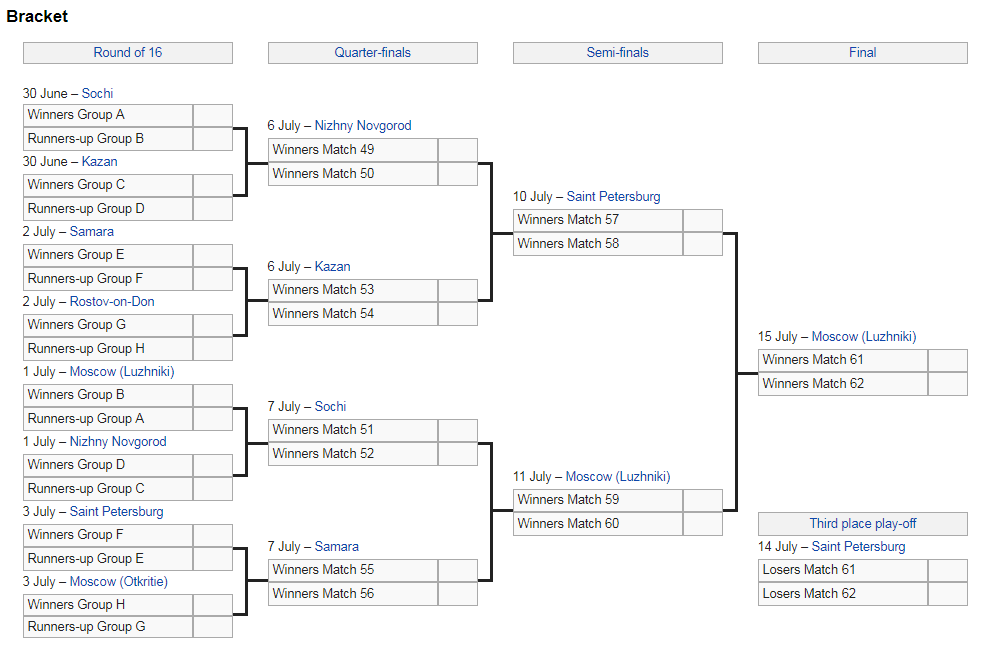


In [ ]:
from numpy.random import choice

def calculate_world_cup_outcome_probabilities(number_of_runs):
    a_first, a_second = single_group_run('Group_A')
    b_first, b_second = single_group_run('Group_B')
    c_first, c_second = single_group_run('Group_C')
    d_first, d_second = single_group_run('Group_D')
    e_first, e_second = single_group_run('Group_E')
    f_first, f_second = single_group_run('Group_F')
    g_first, g_second = single_group_run('Group_G')
    h_first, h_second = single_group_run('Group_H')
    
    q